# Análisis/Síntesis utilizando el modelo de Sinusoides + Residuo FFT y multiresolución en 3 bandas de frecuencia

In [1]:
import sys, os
import math

import numpy as np
from scipy.signal import get_window
from scipy.signal import blackmanharris, triang
from scipy.fftpack import ifft, fftshift

from IPython.display import Audio, display # play file in python notebook

#  https://github.com/MTG/sms-tools
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), 'sms-tools/software/models/'))
import dftModel as DFT
import utilFunctions as UF
import sineModel as SM

In [2]:
# Implementación basada en https://github.com/MTG/sms-tools
def sineModelWithFreqFilter(x, fs, w, N, t, B1, B2):
    """
    Analysis/synthesis of a sound using the sinusoidal model, without sine tracking
    x: input array sound, w: analysis window, N: size of complex spectrum, t: threshold in negative dB
    B1, B2: bandwidth range
    returns y: output array sound
    """
        
    hM1 = int(math.floor((w.size+1)/2))                     # half analysis window size by rounding
    hM2 = int(math.floor(w.size/2))                         # half analysis window size by floor
    Ns = 512                                                # FFT size for synthesis (even)
    H = int(Ns/4)                                                # Hop size used for analysis and synthesis
    hNs = int(Ns/2)                                              # half of synthesis FFT size
    pin = max(hNs, hM1)                                     # init sound pointer in middle of anal window       
    pend = x.size - max(hNs, hM1)                           # last sample to start a frame
    fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
    yw = np.zeros(Ns)                                       # initialize output sound frame
    y = np.zeros(x.size)                                    # initialize output array
    w = w / sum(w)                                          # normalize analysis window
    sw = np.zeros(Ns)                                       # initialize synthesis window
    ow = triang(2*H)                                        # triangular window
    sw[hNs-H:hNs+H] = ow                                    # add triangular window
    bh = blackmanharris(Ns)                                 # blackmanharris window
    bh = bh / sum(bh)                                       # normalized blackmanharris window
    sw[hNs-H:hNs+H] = sw[hNs-H:hNs+H] / bh[hNs-H:hNs+H]     # normalized synthesis window
    while pin<pend:                                         # while input sound pointer is within sound 
    #-----analysis-----             
        x1 = x[pin-hM1:pin+hM2]                               # select frame
        mX, pX = DFT.dftAnal(x1, w, N)                        # compute dft
        ploc = UF.peakDetection(mX, t)                        # detect locations of peaks
        pmag = mX[ploc]                                       # get the magnitude of the peaks
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)   # refine peak values by interpolation
        ipfreq = fs*iploc/float(N)                            # convert peak locations to Hertz
        #Index filtering, with freq between B1 and B2#
        filter_idxs_B1 = np.where(ipfreq>=B1)                # extracts indexes of peaks >=B1
        filter_idxs_B2 = np.where(ipfreq<B2)                 # extracts indexes of peaks <B2
        filter_idxs = np.intersect1d(filter_idxs_B1[0],filter_idxs_B2[0]) #array indexes intersection
        ipfreq = np.array(ipfreq)[filter_idxs]               # filter freq array with filter_idxs
        ipmag = np.array(ipmag)[filter_idxs]                 # filter mag array with filter_idxs 
        ipphase = np.array(ipphase)[filter_idxs]             # filter phase array with filter_idxs
    #-----synthesis-----
        Y = UF.genSpecSines(ipfreq, ipmag, ipphase, Ns, fs)   # generate sines in the spectrum         
        fftbuffer = np.real(ifft(Y))                          # compute inverse FFT
        yw[:hNs-1] = fftbuffer[hNs+1:]                        # undo zero-phase window
        yw[hNs-1:] = fftbuffer[:hNs+1] 
        y[pin-hNs:pin+hNs] += sw*yw                           # overlap-add and apply a synthesis window
        pin += H                                              # advance sound pointer
    return y

def sineModelMultiRes(x, fs, W, N, t, B):
    """
    Analysis/synthesis of a sound using a multi-resolution
    
    sinusoidal model, without sine tracking
    x: input array sound, fs: sampling frequency
    W=[w1,w2,w3]: array of 3 analysis window,
    N=[N1, N2, N3]: array of 3 size of complex spectrum, t: threshold in negative dB
    B=[B1, B2, B3]: three frequency bands
    returns y: output array sound
    """
    w1,w2,w3 = W
    N1,N2,N3 = N
    B1,B2,B3 = B
    
    y1 = sineModelWithFreqFilter(x, fs, w1, N1, t, 0, B1)
    y2 = sineModelWithFreqFilter(x, fs, w2, N2, t, B1, B2)
    y3 = sineModelWithFreqFilter(x, fs, w3, N3, t, B2, B3)
    return y1+y2+y3

# Test code

In [3]:
# Definicion de bandas de frecuencia

#e.g. Given three frequency bands
#B1: 0 <= f < 1000Hz, B2: 1000 <= f < 5000, B3: 5000 <= f < 22050

B1 = 1000
#B1: 0 <= f < 1000Hz, B2: 1000 <= f < 4000, B3: 4000 <= f < 22050
#B2 = 4000
B2 = 5000
B3 = 22050

M1 = 4095
M2 = 2047
M3 = 1023

#window = 'blackman' # Window type
window = 'blackmanharris'  # Window type

t = -80

w1 = get_window(window, M1) 
w2 = get_window(window, M2)
w3 = get_window(window, M3)

N1 = int(pow(2, np.ceil(np.log2(M1))))        # FFT Size, power of 2 larger than M
N2 = int(pow(2, np.ceil(np.log2(M2))))        # FFT Size, power of 2 larger than M
N3 = int(pow(2, np.ceil(np.log2(M3))))        # FFT Size, power of 2 larger than M

W = [w1,w2,w3]
N = [N1, N2, N3]
B = [B1, B2, B3]

In [31]:
# Diferent input files to listen & compare

#inputFile = 'sms-tools/sounds/sines-440-602-hRange.wav'
#inputFile = 'sms-tools/sounds/cello-double.wav'
inputFile = 'sms-tools/sounds/orchestra.wav'

#inputFile = '330868__lawrier__mono-copy-toam-orchestral-loop-with-oriental-touch.wav'
#inputFile = '144971__nightlife999__spirit-cello_mono.wav'

fs, x = UF.wavread(inputFile)  
display(Audio(inputFile))

### Análisis y reconstrucción simple
Con una sola ventana de análisis. La reconstrucción se escucha distorsionada

In [25]:
#with analysis window 1 (for comparing it)
y1 = SM.sineModel(x, fs, w1, N1, t)
outpuSimple = 'output-std.wav'
UF.wavwrite(y1, fs, outpuSimple)
display(Audio(outpuSimple))

### Análisis y reconstrucción utilizando multiresolution FFT

3 Bandas de frecuencia
B1: 0 <= f < 1000Hz, B2: 1000 <= f < 5000, B3: 4000 <= f < 22050

In [24]:
y = sineModelMultiRes(x, fs, W, N, t, B)
outputMultires = 'output-multires.wav'
UF.wavwrite(y, fs, outputMultires)

display(Audio(outputMultires))

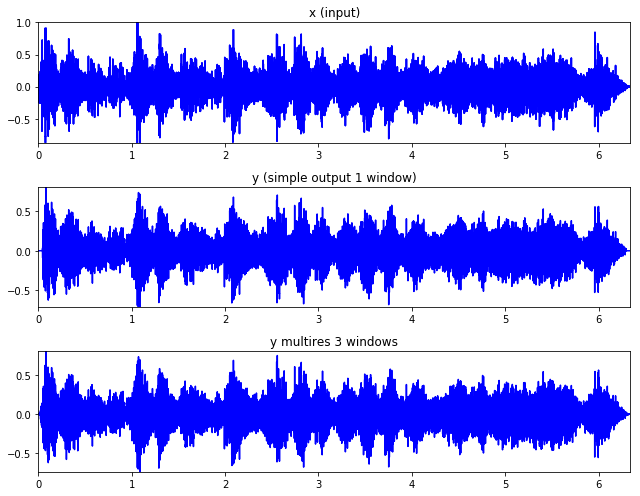

In [22]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(9, 7))

plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x, 'b', lw=1.5)
plt.axis([0,x.size/float(fs),min(x),max(x)])
plt.title('x (input)')                        

plt.subplot(3,1,2)
plt.plot(np.arange(y1.size)/float(fs), y1, 'b', lw=1.5)
plt.axis([0,y1.size/float(fs),min(y1),max(y1)])
plt.title('y (simple output 1 window)')   

plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y, 'b', lw=1.5)
plt.axis([0,y.size/float(fs),min(y),max(y)])
plt.title('y multires 3 windows')   

plt.tight_layout()
#plt.savefig('.png')
plt.show()

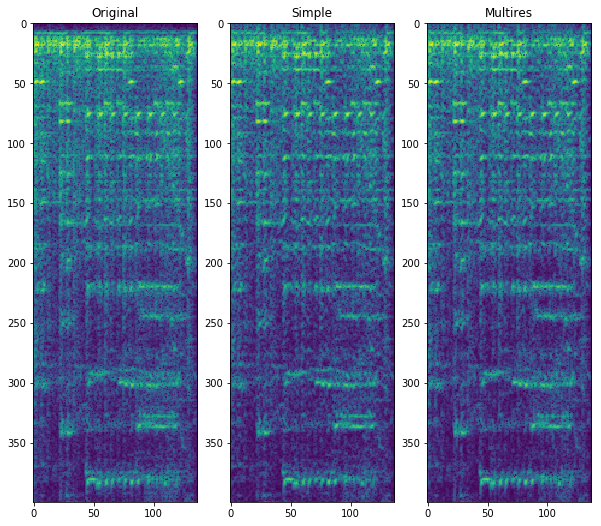

In [43]:
#spectrogram

import librosa
# Reads wav file and produces spectrum
# Fourier phases are ignored
#N_FFT = 2048
N_FFT = 4096
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(read_audio_spectum(inputFile)[0][:400,:])
plt.subplot(1, 3, 2)
plt.title('Simple')
plt.imshow(read_audio_spectum(outpuSimple)[0][:400,:])
plt.subplot(1, 3, 3)
plt.title('Multires')
plt.imshow(read_audio_spectum(outputMultires)[0][:400,:])
plt.show()